### This notebook sets up a Kalman filter and demonstrates how choice of parameters impact the updating

### 1. Loading required python modules and setting path to SHyFT installation

In [1]:
# first you should import the third-party python modules which you'll use later on
# the first line enables that figures are shown inline, directly in the notebook
%matplotlib inline
import datetime
import numpy as np
import os
from os import path
import sys # once the shyft_path is set correctly, you should be able to import shyft modules

# set the path for your shyft build
# this should point to the directory that is created
# when you clone shyft, assuming you have built shyft
# there and not installed it to your system python
shyft_path = os.path.abspath("../../../shyft")
sys.path.insert(0, shyft_path)

import shyft
# from shyft import shyftdata_dir

from shyft import api
from matplotlib import pyplot as plt

### 2. Create Kalman filter

In [2]:
# Create the Kalman filter having 8 samples spaced every 3 hours to represent a daily periodic pattern
p=api.KalmanParameter()
kf = api.KalmanFilter(p)
# Check default parameters
print(kf.parameter.n_daily_observations)
print(kf.parameter.hourly_correlation)
print(kf.parameter.covariance_init)
print(kf.parameter.ratio_std_w_over_v)
print(kf.parameter.std_error_bias_measurements)
# help(kf)
# help(api.KalmanState)

8
0.93
0.5
0.15
2.0


### 3. Creates start states

In [3]:
# Create initial states
s=kf.create_initial_state()
# Check systemic variance matrix and default start states
# Note that coefficients in matrix W are of form 
# (std_error_bias_measurements*ratio_std_w_over_v)^2*hourly_correlation^|i-j|, 
# while coeffisients of P are of same form but with different variance.
print(np.array_str(s.W, precision=4, suppress_small=True))
print("")
print(np.array_str(s.P, precision=4, suppress_small=True))
print("")
print(np.array_str(s.x, precision=4, suppress_small=True))
print(np.array_str(s.k, precision=4, suppress_small=True))

[[0.09   0.0724 0.0582 0.0468 0.0377 0.0468 0.0582 0.0724]
 [0.0724 0.09   0.0724 0.0582 0.0468 0.0377 0.0468 0.0582]
 [0.0582 0.0724 0.09   0.0724 0.0582 0.0468 0.0377 0.0468]
 [0.0468 0.0582 0.0724 0.09   0.0724 0.0582 0.0468 0.0377]
 [0.0377 0.0468 0.0582 0.0724 0.09   0.0724 0.0582 0.0468]
 [0.0468 0.0377 0.0468 0.0582 0.0724 0.09   0.0724 0.0582]
 [0.0582 0.0468 0.0377 0.0468 0.0582 0.0724 0.09   0.0724]
 [0.0724 0.0582 0.0468 0.0377 0.0468 0.0582 0.0724 0.09  ]]

[[0.5    0.4022 0.3235 0.2602 0.2093 0.2602 0.3235 0.4022]
 [0.4022 0.5    0.4022 0.3235 0.2602 0.2093 0.2602 0.3235]
 [0.3235 0.4022 0.5    0.4022 0.3235 0.2602 0.2093 0.2602]
 [0.2602 0.3235 0.4022 0.5    0.4022 0.3235 0.2602 0.2093]
 [0.2093 0.2602 0.3235 0.4022 0.5    0.4022 0.3235 0.2602]
 [0.2602 0.2093 0.2602 0.3235 0.4022 0.5    0.4022 0.3235]
 [0.3235 0.2602 0.2093 0.2602 0.3235 0.4022 0.5    0.4022]
 [0.4022 0.3235 0.2602 0.2093 0.2602 0.3235 0.4022 0.5   ]]

[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]


### 4. Update filter

In [4]:
# Create a bias temperature observation series with some noise, update the filter,
# and for each update save the states belonging to the first segment of the day
number_days = 10
observation = np.empty((8*number_days,1))
kalman_gain = np.empty((8*number_days,1))
std_P = np.empty((8*number_days,1))
learning = np.empty((8*number_days,1))
for i in range(len(observation)):
    obs_bias = 2 + 0.3*np.random.randn() # Expected bias = 2 with noise
    kf.update(obs_bias,api.deltahours(i*3),s)
    std_P[i] = pow(s.P[0,0],0.5) # Values for hour 0000 UTC
    observation[i] = obs_bias
    kalman_gain[i] = s.k[0] # Values for hour 0000 UTC
    learning[i] = s.x[0] # Values for hour 0000 UTC

In [5]:
# help(api.TimeSeries)

### 5. Plot results

Text(0.5,1,'State development for first time segment')

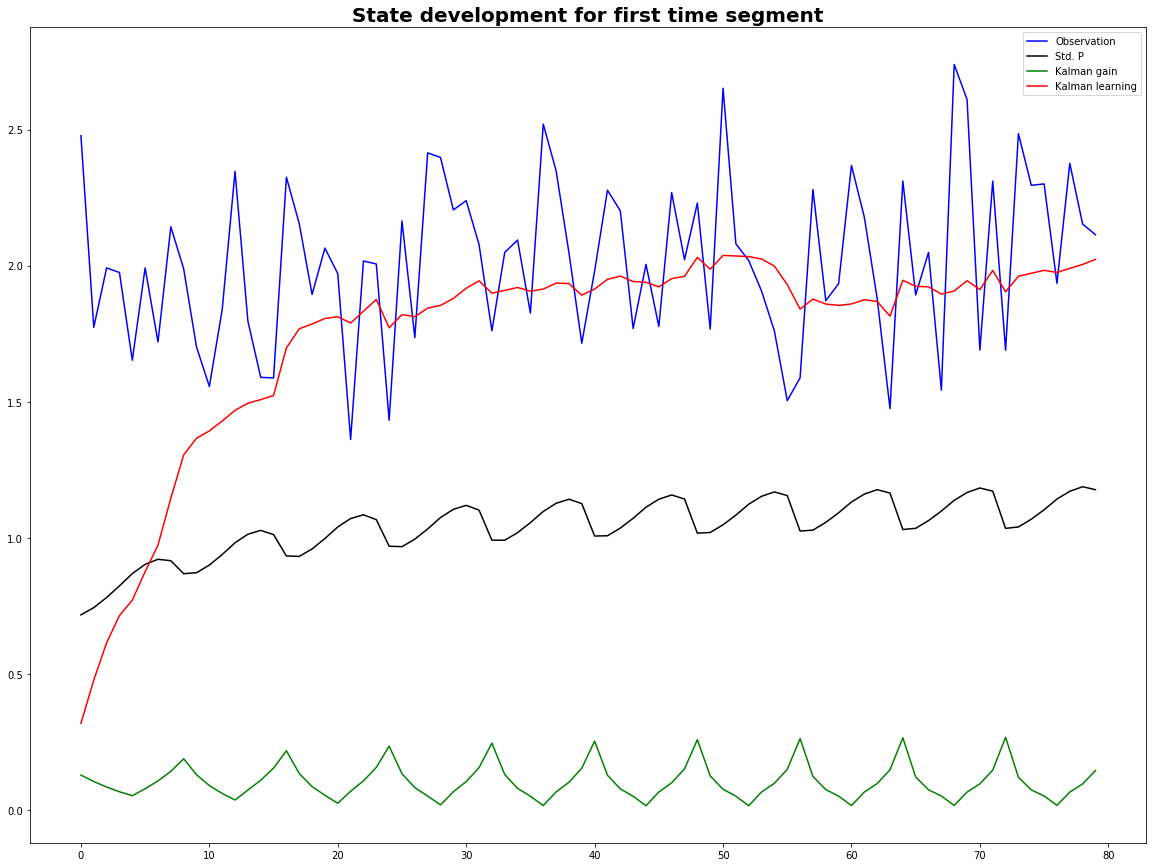

In [6]:
fig, ax = plt.subplots(figsize=(20,15))
ax.plot(observation, 'b', label = 'Observation')
ax.plot(std_P, 'k', label = 'Std. P')
ax.plot(kalman_gain, 'g', label = 'Kalman gain')
ax.plot(learning, 'r', label = 'Kalman learning')
ax.legend()
ax.set_title('State development for first time segment', fontsize=20, fontweight = 'bold')

### 6. Test to see how choice of parameters impact filter

Text(0.5,1,'State development for first time segment')

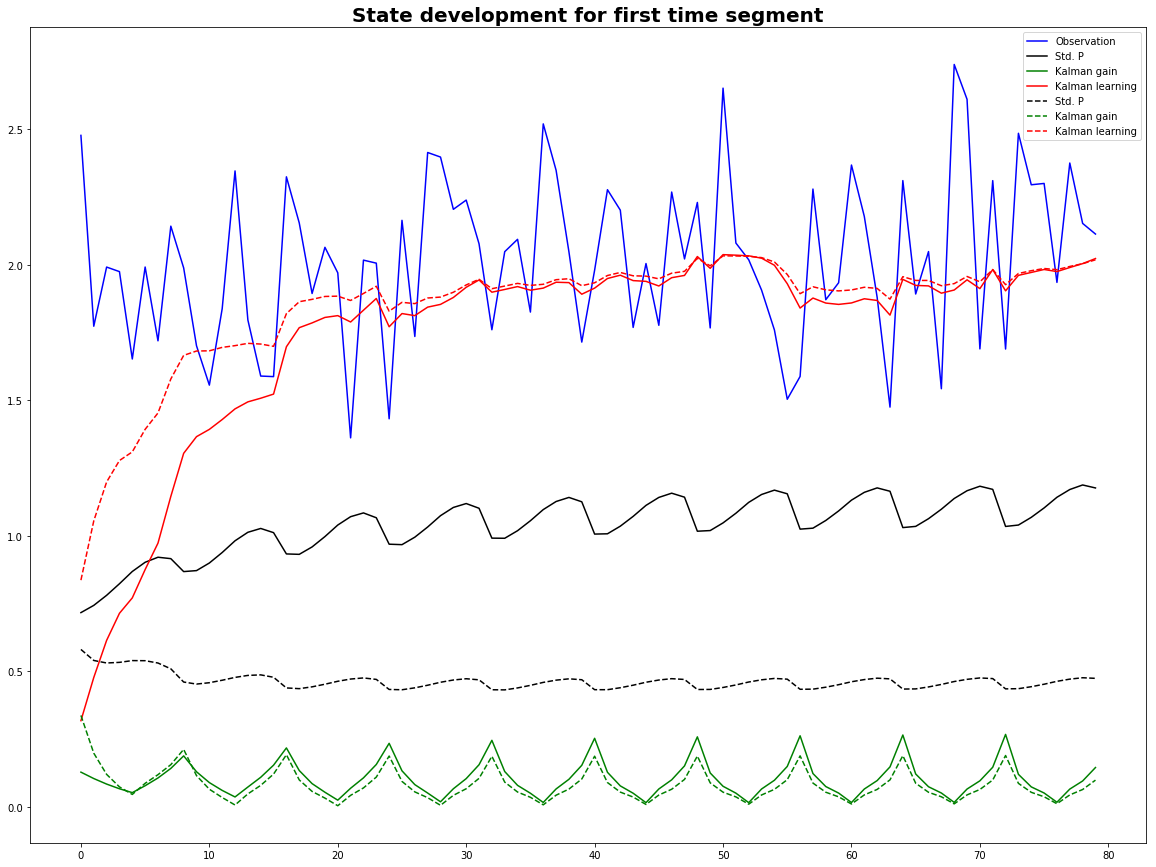

In [7]:
# Create new parameters and filter 
p_new = api.KalmanParameter()
p_new.std_error_bias_measurements = 1
p_new.ratio_std_w_over_v = 0.10
kf_new = api.KalmanFilter(p_new)

# Initial states
s_new = kf_new.create_initial_state()
# Update with same observation as above
kalman_gain_new = np.empty((8*number_days,1))
std_P_new = np.empty((8*number_days,1))
learning_new = np.empty((8*number_days,1))
for i in range(len(observation)):
    kf_new.update(observation.item(i),api.deltahours(i*3),s_new)
    std_P_new[i] = pow(s_new.P[0,0],0.5) # Values for hour 0000 UTC
    kalman_gain_new[i] = s_new.k[0] # Values for hour 0000 UTC
    learning_new[i] = s_new.x[0] # Values for hour 0000 UTC
# Plot results
fig, ax = plt.subplots(figsize=(20,15))
ax.plot(observation, 'b', label = 'Observation')
ax.plot(std_P, 'k', label = 'Std. P')
ax.plot(kalman_gain, 'g', label = 'Kalman gain')
ax.plot(learning, 'r', label = 'Kalman learning')
ax.plot(std_P_new, 'k--', label = 'Std. P')
ax.plot(kalman_gain_new, 'g--', label = 'Kalman gain')
ax.plot(learning_new, 'r--', label = 'Kalman learning')
ax.legend()
ax.set_title('State development for first time segment', fontsize=20, fontweight = 'bold')